# Random Forest Model

- Plot graphs showing training performance as a function of parameters

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [4]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [5]:
from kaggle_wrapper_lib import kaggle_competition_submit
from kaggle_wrapper_lib import kaggle_competition_submissions

In [6]:
from loan_approval_lib.standard_data_processing import data_cleaning_algorithm
from loan_approval_lib.standard_data_processing import create_loan_grade_numerical_from_loan_grade
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot
from loan_approval_lib.standard_data_processing import map_cb_person_default_on_file
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id
from loan_approval_lib.standard_data_processing import create_dataframe_copy_and_drop_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id

In [ ]:
#import warnings
#from sklearn.exceptions import UserWarning
#warnings.filterwarnings(action='ignore', category=UserWarning)

In [7]:
data = loan_approval_lib.load_original_data()

In [8]:
data_train = loan_approval_lib.load_data_train()

In [9]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning, Data Preprocessing

In [10]:
data = data_cleaning_algorithm(data)

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [11]:
data_train = data_cleaning_algorithm(data_train)

column person_age, number of removed rows: 1
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 2
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [12]:
data_cleaning_algorithm(data_test)
None

column person_age, number of removed rows: 0
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 0
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [13]:
# Loan Grade

create_loan_grade_numerical_from_loan_grade(data, data_train, data_test)

In [14]:
# Person Home Ownership

encoder = create_person_home_ownership_one_hot_encoder(data)

data = create_person_home_ownership_one_hot(encoder, data)
data_train = create_person_home_ownership_one_hot(encoder, data_train)
data_test = create_person_home_ownership_one_hot(encoder, data_test)

In [15]:
# Loan Intent

encoder = create_loan_intent_one_hot_encoder(data)

data = create_loan_intent_one_hot(encoder, data)
data_train = create_loan_intent_one_hot(encoder, data_train)
data_test = create_loan_intent_one_hot(encoder, data_test)

In [16]:
# Default On File

data = map_cb_person_default_on_file(data)
data_train = map_cb_person_default_on_file(data_train)
data_test = map_cb_person_default_on_file(data_test)

# Choose Columns for Tree Model, Copy DataFrame and Drop Unused Columns

In [17]:
decision_tree_columns = create_decision_tree_columns()
decision_tree_columns_with_id = create_decision_tree_columns_with_id()

In [18]:
data_copy = create_dataframe_copy_and_drop_columns(data)
data_train_copy = create_dataframe_copy_and_drop_columns(data_train)
data_test_copy = create_dataframe_copy_and_drop_columns(data_test)

# Random Forest Model

In [19]:
def random_forest_model_train(
    data_train,
    decision_tree_columns,
    n_estimators,
    max_features,
    max_depth,
    min_samples_split,
    min_samples_leaf,
    bootstrap,
    n_jobs,
):

    X = data_train[decision_tree_columns].copy()
    Y = data_train['loan_status'].copy()
    
    clf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        criterion='entropy',
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        n_jobs=n_jobs,
        oob_score=True,
        
    )
    clf.fit(X, Y)
    
    Z = clf.predict(X)
    X['loan_status_predict'] = Z
    X['loan_status'] = data_train['loan_status']
    accuracy_in_sample = (X['loan_status'] == X['loan_status_predict']).sum() / len(X)
    
    return (clf, accuracy_in_sample)

In [20]:
def random_forest_model_test(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = clf.predict(X_test)
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy_out_of_sample = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy_out_of_sample

In [21]:
def random_forest_model_predict(
    clf,
    data_predict,
    decision_tree_columns,
    decision_tree_columns_with_id,
):
    
    X_predict = data_predict[decision_tree_columns_with_id].copy()

    Z_predict = clf.predict_proba(X_predict[decision_tree_columns])
    X_predict['loan_status'] = Z_predict[:, 1]

    return X_predict

In [22]:
def random_forest_model_predict_write_to_csv(
    data_predict,
    filename,
):
    data_predict[['id', 'loan_status']].to_csv(filename, index=False)

# Optimize Choice of Dataset

In [26]:
all_training_data = pandas.concat(
    [data_copy, data_train_copy],
    axis=0,
)
all_training_data.reset_index(inplace=True, drop=True)

In [27]:
permutation = numpy.random.permutation(all_training_data.index)

In [28]:
n_samples = len(all_training_data)
n_samples

87274

In [29]:
k = 100

In [30]:
fold_sizes = numpy.full(k, n_samples // k, dtype=int)
fold_sizes

array([872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [31]:
fold_sizes[:n_samples % k] += 1
fold_sizes

array([873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [32]:
index = 0
folds = []
for fold_size in fold_sizes:
    start = index
    stop = index + fold_size
    folds.append(permutation[start:stop])
    index = stop

In [38]:
numpy.unique(numpy.logspace(0, 2, num=50, endpoint=True, base=10.0, dtype=int))

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        15,  16,  18,  20,  22,  24,  26,  29,  32,  35,  39,  42,  47,
        51,  56,  62,  68,  75,  82,  91, 100])

In [37]:
def kaggle_competition_submit_and_get_public_private_score_sync(filename, message):
    
    _ = kaggle_competition_submit(
        filename,
        message_tag
    )

    # TODO: Can make this faster with async logic
    while True:
        submissions = kaggle_competition_submissions()
        filtered_submissions = submissions[submissions['description'] == message_tag]
        assert len(filtered_submissions) == 1, f'invalid number of filtered submissions {len(filtered_submissions)}'
        status = filtered_submissions['status'][0]
        if status == 'SubmissionStatus.COMPLETE':
            break
        elif status == 'SubmissionStatus.PENDING':
            pass
        else:
            print(f'status={status}')

    public_score = filtered_submissions['publicScore'][0]
    private_score = filtered_submissions['privateScore'][0]

    return (public_score, private_score)

In [40]:
df = pandas.DataFrame(
    {
        'estimators': n_estimators_list,
        'features': n_features_list,
        'accuracy_in_sample': accuracy_in_sample_list,
        'accuracy_out_of_sample': accuracy_out_of_sample_list,
        'oob_score': oob_score_list,
        'public_score': public_score_list,
        'private_score': private_score_list,
    }
)

In [41]:
df.loc[df['features'].isna(), 'features'] = 'none'

In [88]:
df.to_csv('random_forest_3_raw_data.csv', index=True)

# Load dataset for plotting

In [13]:
df = pandas.read_csv('random_forest_3_raw_data.csv', index_col=0)

In [14]:
df

,estimators,features,accuracy_in_sample,accuracy_out_of_sample,oob_score,public_score,private_score
0,1,sqrt,0.936922,0.908362,0.863983,NaN,NaN
1,1,sqrt,0.939457,0.924399,0.865881,NaN,NaN
2,1,sqrt,0.938959,0.918671,0.865765,NaN,NaN
3,1,sqrt,0.938056,0.912944,0.864712,NaN,NaN
4,1,sqrt,0.939283,0.922108,0.866761,NaN,NaN
...,...,...,...,...,...,...,...
10195,100,none,0.961841,0.950688,0.946772,NaN,NaN
10196,100,none,0.962038,0.948394,0.946610,NaN,NaN
10197,100,none,0.962049,0.950688,0.946749,NaN,NaN
10198,100,none,0.962212,0.946101,0.946911,NaN,NaN


In [42]:
# don't run this cell - this was the data which was saved
#df

,estimators,features,accuracy_in_sample,accuracy_out_of_sample,oob_score,public_score,private_score
0,1,sqrt,0.936922,0.908362,0.863983,NaN,NaN
1,1,sqrt,0.939457,0.924399,0.865881,NaN,NaN
2,1,sqrt,0.938959,0.918671,0.865765,NaN,NaN
3,1,sqrt,0.938056,0.912944,0.864712,NaN,NaN
4,1,sqrt,0.939283,0.922108,0.866761,NaN,NaN
...,...,...,...,...,...,...,...
10195,100,none,0.961841,0.950688,0.946772,NaN,NaN
10196,100,none,0.962038,0.948394,0.946610,NaN,NaN
10197,100,none,0.962049,0.950688,0.946749,NaN,NaN
10198,100,none,0.962212,0.946101,0.946911,NaN,NaN


# Aggregate data for line graphs

In [58]:
aggregation_spec = {
    f'{input_column}': [
        (f'{input_column}_mean', 'mean'),
        (f'{input_column}_median', 'median'),
        (f'{input_column}_min', 'min'),
        (f'{input_column}_max', 'max'),
        (f'{input_column}_q1', lambda x: x.quantile(0.25)),
        (f'{input_column}_q3', lambda x: x.quantile(0.75)),
    ]
    for input_column in [
        'accuracy_in_sample',
        'accuracy_out_of_sample',
        'oob_score',
        'public_score',
        'private_score',
    ]
}

In [60]:
df_aggregated = df.groupby(
    by=['estimators', 'features']
).aggregate(
    aggregation_spec
)

df_aggregated.columns = [column[1] for column in df_aggregated.columns]

df_aggregated.reset_index(inplace=True)

In [61]:
df_aggregated

,estimators,features,accuracy_in_sample_mean,accuracy_in_sample_median,accuracy_in_sample_min,accuracy_in_sample_max,accuracy_in_sample_q1,accuracy_in_sample_q3,accuracy_out_of_sample_mean,accuracy_out_of_sample_median,...,public_score_min,public_score_max,public_score_q1,public_score_q3,private_score_mean,private_score_median,private_score_min,private_score_max,private_score_q1,private_score_q3
0,1,log2,0.938986,0.939087,0.934851,0.942721,0.937796,0.940189,0.923081,0.923253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,none,0.946488,0.946442,0.944387,0.947918,0.946016,0.947055,0.919610,0.918671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,sqrt,0.938823,0.938947,0.934596,0.941795,0.937787,0.940004,0.921752,0.920962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,log2,0.950165,0.950197,0.948334,0.951633,0.949772,0.950591,0.936625,0.936999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,none,0.959242,0.959283,0.957489,0.960499,0.958887,0.959607,0.939100,0.938717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,91,none,0.962022,0.961991,0.961598,0.962651,0.961896,0.962142,0.947098,0.947308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,91,sqrt,0.951273,0.951285,0.950741,0.951737,0.951167,0.951389,0.946055,0.946163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,100,log2,0.951249,0.951228,0.950961,0.951714,0.951135,0.951366,0.945619,0.946163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,100,none,0.962009,0.962026,0.961575,0.962732,0.961875,0.962099,0.946846,0.947308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df_aggregated[df_aggregated['features'] == 'sqrt'].sort_values(by=['accuracy_out_of_sample_median'])

,estimators,features,accuracy_in_sample_mean,accuracy_in_sample_median,accuracy_in_sample_min,accuracy_in_sample_max,accuracy_in_sample_q1,accuracy_in_sample_q3,accuracy_out_of_sample_mean,accuracy_out_of_sample_median,...,public_score_min,public_score_max,public_score_q1,public_score_q3,private_score_mean,private_score_median,private_score_min,private_score_max,private_score_q1,private_score_q3
2,1,sqrt,0.938823,0.938947,0.934596,0.941795,0.937787,0.940004,0.921752,0.920962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,sqrt,0.950369,0.950400,0.948079,0.951957,0.949943,0.950901,0.937014,0.936927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3,sqrt,0.952259,0.952281,0.950973,0.953426,0.951899,0.952631,0.941907,0.942726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,4,sqrt,0.952672,0.952703,0.951644,0.953751,0.952420,0.952932,0.943053,0.943267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,5,sqrt,0.952692,0.952703,0.951795,0.953496,0.952399,0.952981,0.943660,0.943872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,6,sqrt,0.952602,0.952651,0.951853,0.953322,0.952374,0.952802,0.944118,0.943872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,7,sqrt,0.952512,0.952477,0.951864,0.953288,0.952292,0.952747,0.944451,0.944413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,9,sqrt,0.952314,0.952292,0.951528,0.953311,0.952110,0.952527,0.945047,0.945017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,35,sqrt,0.951516,0.951494,0.951031,0.951946,0.951352,0.951682,0.945562,0.945017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,20,sqrt,0.951726,0.951725,0.951181,0.952327,0.951552,0.951879,0.945654,0.945017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plot features = 'sqrt' in sample accuracy

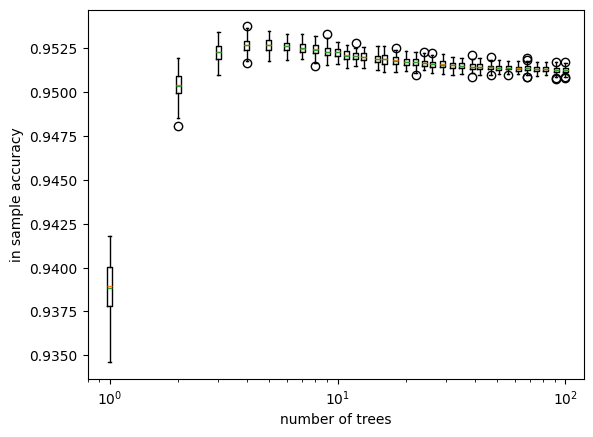

In [51]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_in_sample']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('in sample accuracy')

None

# Plot features = 'log2' in sample accuracy

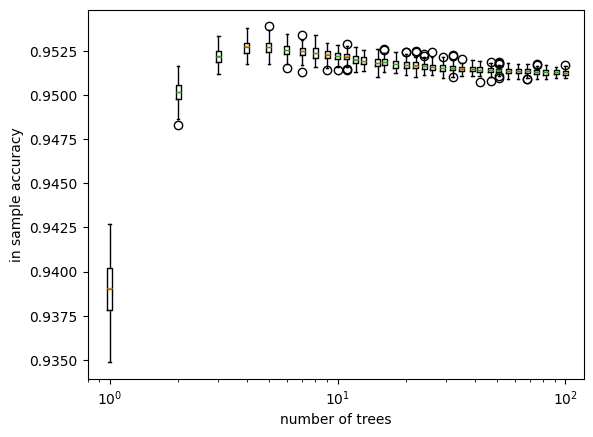

In [15]:
plt.figure()

df_select = df[df['features'] == 'log2']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_in_sample']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('in sample accuracy')

None

# Plot features = 'none' in sample accuracy

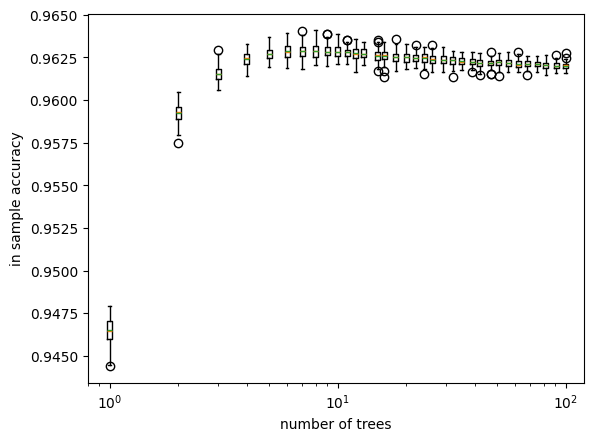

In [16]:
plt.figure()

df_select = df[df['features'] == 'none']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_in_sample']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('in sample accuracy')

None

# Plot features = 'sqrt' out of sample accuracy

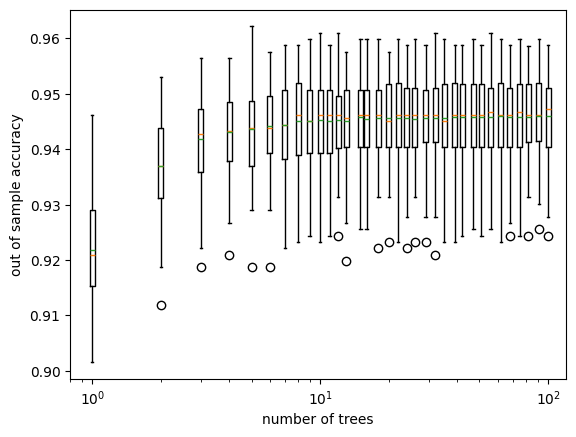

In [50]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_out_of_sample']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('out of sample accuracy')

None

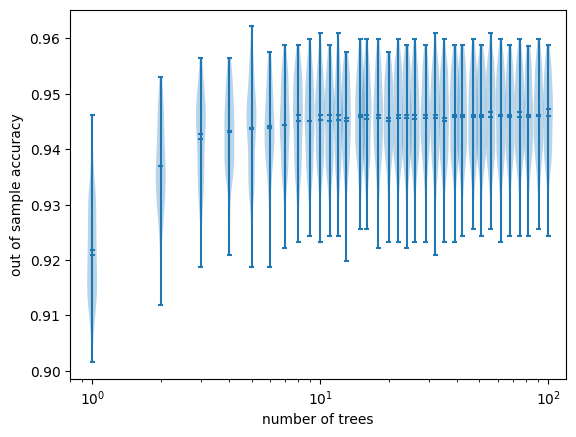

In [57]:
# violin plot

plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_out_of_sample']
    )
    positions.append(
        estimators_
    )

plt.violinplot(
    x,
    positions=positions,
    orientation='vertical',
    widths=[0.1 * position for position in positions],
    showmeans=True,
    showmedians=True,
    showextrema=True,
    #quantiles=[0.25,0.75],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('out of sample accuracy')

None

# Plot features = 'log2' out of sample accuracy

- `log2(19)` ~ `sqrt(19)`

# Plot features = 'none' out of sample accuracy

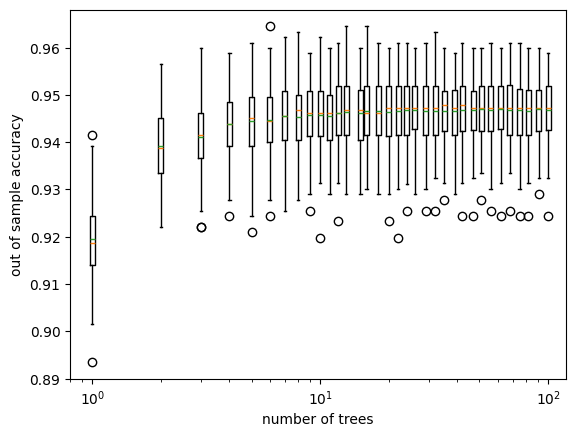

In [17]:
plt.figure()

df_select = df[df['features'] == 'none']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_out_of_sample']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('out of sample accuracy')

None

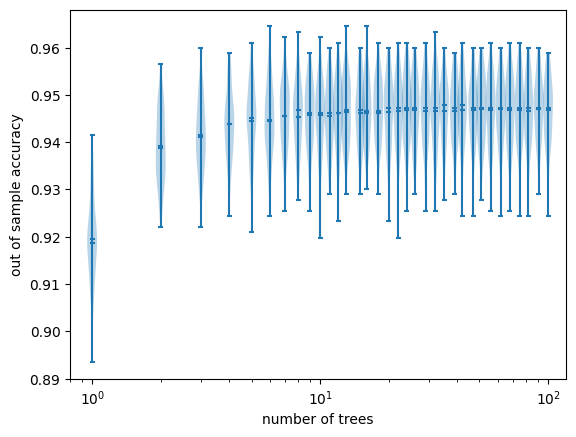

In [18]:
# violin plot

plt.figure()

df_select = df[df['features'] == 'none']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_out_of_sample']
    )
    positions.append(
        estimators_
    )

plt.violinplot(
    x,
    positions=positions,
    orientation='vertical',
    widths=[0.1 * position for position in positions],
    showmeans=True,
    showmedians=True,
    showextrema=True,
    #quantiles=[0.25,0.75],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('out of sample accuracy')

None

# Plot features = 'sqrt' out of bag accuracy

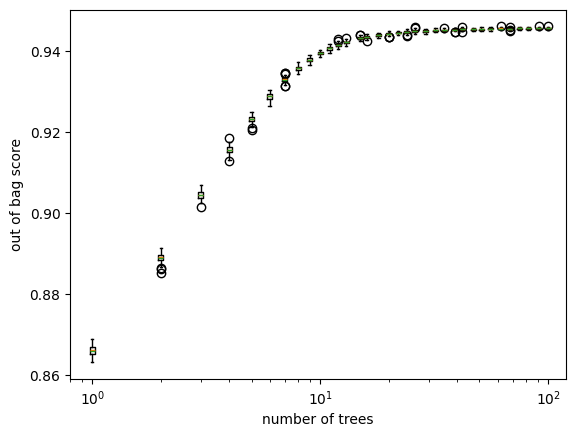

In [52]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['oob_score']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('out of bag score')

None

# Plot features = 'none' out of bag accuracy

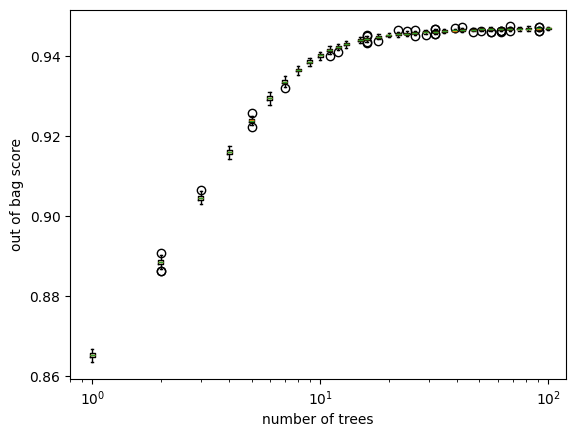

In [19]:
plt.figure()

df_select = df[df['features'] == 'none']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['oob_score']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('out of bag score')

None

# Plot features = 'sqrt' in sample accuracy (lines)

In [75]:
df_select = df_aggregated[df_aggregated['features'] == 'sqrt']

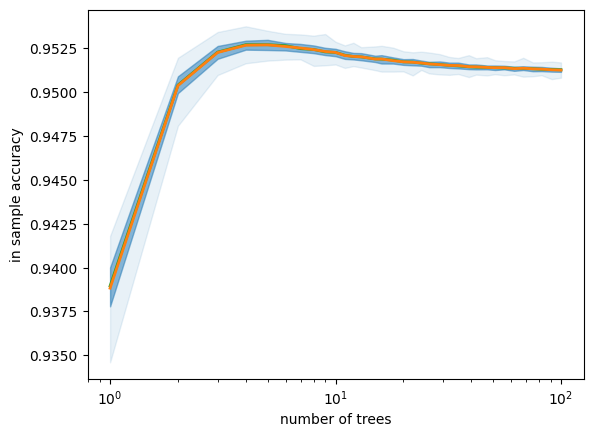

In [83]:
plt.figure()

plt.fill_between(
    df_select['estimators'],
    df_select['accuracy_in_sample_min'],
    df_select['accuracy_in_sample_max'],
    color='tab:blue',
    alpha=0.1,
    label='range',
)

plt.fill_between(
    df_select['estimators'],
    df_select['accuracy_in_sample_q1'],
    df_select['accuracy_in_sample_q3'],
    color='tab:blue',
    alpha=0.5,
    label='range',
)

plt.plot(
    df_select['estimators'],
    df_select['accuracy_in_sample_median'],
    color='tab:green',
    label='median',
    linewidth=2,
)

plt.plot(
    df_select['estimators'],
    df_select['accuracy_in_sample_mean'],
    color='tab:orange',
    label='mean',
    linewidth=2,
)

plt.xscale('log')
#plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('in sample accuracy')

None

# Plot features = 'sqrt' out of sample accuracy (lines)

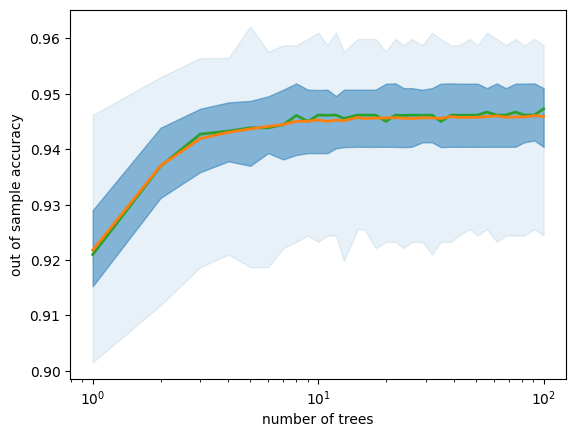

In [87]:
plt.figure()

plt.fill_between(
    df_select['estimators'],
    df_select['accuracy_out_of_sample_min'],
    df_select['accuracy_out_of_sample_max'],
    color='tab:blue',
    alpha=0.1,
    label='range',
)

plt.fill_between(
    df_select['estimators'],
    df_select['accuracy_out_of_sample_q1'],
    df_select['accuracy_out_of_sample_q3'],
    color='tab:blue',
    alpha=0.5,
    label='range',
)

plt.plot(
    df_select['estimators'],
    df_select['accuracy_out_of_sample_median'],
    color='tab:green',
    label='median',
    linewidth=2,
)

plt.plot(
    df_select['estimators'],
    df_select['accuracy_out_of_sample_mean'],
    color='tab:orange',
    label='mean',
    linewidth=2,
)

plt.xscale('log')
#plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('out of sample accuracy')

None

# Plot features = 'sqrt' out of bag accuracy (lines)

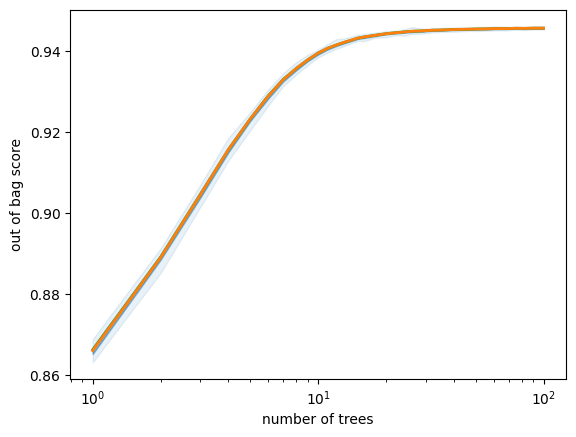

In [86]:
plt.figure()

plt.fill_between(
    df_select['estimators'],
    df_select['oob_score_min'],
    df_select['oob_score_max'],
    color='tab:blue',
    alpha=0.1,
    label='range',
)

plt.fill_between(
    df_select['estimators'],
    df_select['oob_score_q1'],
    df_select['oob_score_q3'],
    color='tab:blue',
    alpha=0.5,
    label='range',
)

plt.plot(
    df_select['estimators'],
    df_select['oob_score_median'],
    color='tab:green',
    label='median',
    linewidth=2,
)

plt.plot(
    df_select['estimators'],
    df_select['oob_score_mean'],
    color='tab:orange',
    label='mean',
    linewidth=2,
)

plt.xscale('log')
#plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('number of trees')
plt.ylabel('out of bag score')

None